In [1]:
import pickle
import pandas as pd
import pickle
caminho_arquivo = "/Users/joao altarugio/Desktop/IC - Levada/DataGeral/bova11_teste.pkl"
with open(caminho_arquivo, "rb") as f:
   df = pickle.load(f)
df

,Close
Date,
2015-01-05,46.320000
2015-01-06,46.580002
2015-01-07,48.150002
2015-01-08,48.509998
2015-01-09,47.529999
...,...
2025-04-28,131.649994
2025-04-29,131.860001
2025-04-30,131.630005


#TF


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

###Dividir os dados
Você usará uma divisão (70%, 20%, 10%) para os conjuntos de treinamento, validação e teste. Observe que os dados não estão sendo embaralhados aleatoriamente antes da divisão. Isso por dois motivos:

Garante que ainda é possível cortar os dados em janelas de amostras consecutivas.
Garante que os resultados da validação/teste sejam mais realistas, sendo avaliados nos dados coletados após o treinamento do modelo.

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

###Normalize os dados
É importante dimensionar recursos antes de treinar uma rede neural. A normalização é uma maneira comum de fazer essa escala: subtrair a média e dividir pelo desvio padrão de cada recurso.

A média e o desvio padrão só devem ser calculados usando os dados de treinamento para que os modelos não tenham acesso aos valores nos conjuntos de validação e teste.

In [4]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.fit_transform(val_df)
test_df = scaler.fit_transform(test_df)

In [5]:
Colunas = print(df.columns)

Index(['Close'], dtype='object')


In [6]:
train_df = pd.DataFrame(train_df, columns=['Close'])
val_df = pd.DataFrame(val_df, columns=['Close'])
test_df = pd.DataFrame(test_df, columns=['Close'])

Classe **WindowGenerator** . Esta classe pode:

Manipule os índices e deslocamentos.
Divida janelas de recursos em pares (features, labels) .
Plote o conteúdo das janelas resultantes.
Gere lotes dessas janelas com eficiência a partir dos dados de treinamento, avaliação e teste, usando tf.data.Dataset s.

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Exemplos de uso da classe WindowGenerator

In [8]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Close'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Close']

In [9]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Close']

A função split_window é usada para dividir os dados de séries temporais em entradas (inputs) e saídas (targets). Isso é essencial porque modelos de aprendizado profundo precisam aprender padrões a partir de sequências passadas para prever valores futuros.

Motivo para dividir a janela
Séries temporais são compostas por observações ao longo do tempo. Para que uma rede neural consiga prever um valor futuro, precisamos fornecer janelas de dados históricos como entrada. Essa janela precisa ser dividida entre:

Inputs (X): Dados históricos usados para prever.

Targets (Y): Valores futuros que queremos prever.




In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Este diagrama não mostra o eixo de features dos dados, mas essa função split_window também manipula o label_columns para que possa ser usado para exemplos de saída única e saída múltipla.

In [11]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


###Trama
Aqui está um método de plotagem que permite uma visualização simples da janela dividida, não estamos usando:

In [12]:
w2.example = example_inputs, example_labels

In [13]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

In [ ]:
w2.plot()

###Crie tf.data.Dataset s
Finalmente, este método make_dataset um DataFrame de série temporal e o converterá em um tf.data.Dataset de (input_window, label_window) usando a função tf.keras.utils.timeseries_dataset_from_array :

In [15]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

O objeto WindowGenerator contém dados de treinamento, validação e teste.

Adicione propriedades para acessá-los como tf.data.Dataset s usando o método make_dataset definido anteriormente. Além disso, adicione um lote de exemplo padrão para fácil acesso e plotagem:

In [16]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Agora, o objeto WindowGenerator fornece acesso aos objetos tf.data.Dataset , para que você possa iterar facilmente sobre os dados.

A propriedade Dataset.element_spec informa a estrutura, os tipos de dados e as formas dos elementos do conjunto de dados.

In [17]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Baseline, copia os ultimos 5 dados do passado como previsão

In [18]:
# --------------------------------------
# 1. RECRIAÇÃO DO WIDE_WINDOW
# --------------------------------------
wide_window = WindowGenerator(
    input_width=5,
    label_width=5,
    shift=5,
    label_columns=['Close']
)

# --------------------------------------
# 2. ÍNDICE DA COLUNA 'Close'
# --------------------------------------
column_indices = {name: i for i, name in enumerate(wide_window.train.element_spec[0].shape[-1] * [''])}
column_indices['Close'] = 0  # força para univariado se necessário

# --------------------------------------
# 3. BASELINE (repete os últimos valores como estão)
# --------------------------------------
class Baseline(tf.keras.Model):
    def call(self, inputs):
        return inputs  # retorno direto das últimas entradas

# --------------------------------------
# 4. INSTANCIAR, COMPILAR E AVALIAR
# --------------------------------------
baseline = Baseline()

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline_5x5'] = baseline.evaluate(wide_window.val)
performance['Baseline_5x5'] = baseline.evaluate(wide_window.test, verbose=0)

# --------------------------------------
# 5. PLOT
# --------------------------------------
#wide_window.plot(baseline)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0651 - mean_absolute_error: 0.1995  


#Compile

In [19]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#CNNs - Rede neural de convolução

---

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt

# --------------------------------------
# 1. GERADOR DE JANELAS
# --------------------------------------
wide_conv_window = WindowGenerator(
    input_width=5,
    label_width=5,
    shift=5,
    label_columns=['Close']
)

# --------------------------------------
# 2. PARÂMETROS DINÂMICOS
# --------------------------------------
sequence_length = wide_conv_window.example[0].shape[1]
num_features = wide_conv_window.example[0].shape[2]

# --------------------------------------
# 3. MODELO CNN (com TimeDistributed)
# --------------------------------------
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(5, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(5)  # previsão para 5 dias
])

# --------------------------------------
# 4. FUNÇÃO DE COMPILAÇÃO E TREINAMENTO
# --------------------------------------
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae'])

    history = model.fit(window.train,
                        epochs=20,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

# --------------------------------------
# 5. TREINAMENTO
# --------------------------------------
history = compile_and_fit(cnn_model, wide_conv_window)

# --------------------------------------
# 6. AVALIAÇÃO
# --------------------------------------

val_performance['CNN_5x5'] = cnn_model.evaluate(wide_conv_window.val)
performance['CNN_5x5'] = cnn_model.evaluate(wide_conv_window.test, verbose=0)

# --------------------------------------
# 7. VISUALIZAÇÃO
# --------------------------------------
#wide_conv_window.plot(cnn_model)


Epoch 1/20


c:\Users\joao altarugio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1837 - mae: 0.3480 - val_loss: 0.0604 - val_mae: 0.1961
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - mae: 0.0588 - val_loss: 0.0566 - val_mae: 0.1875
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - mae: 0.0454 - val_loss: 0.0537 - val_mae: 0.1814
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - mae: 0.0401 - val_loss: 0.0528 - val_mae: 0.1795
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0393 - val_loss: 0.0521 - val_mae: 0.1780
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - mae: 0.0391 - val_loss: 0.0511 - val_mae: 0.1768
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mae: 0.0384 - val_loss: 0.0506 - val_mae: 0.1752
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - mae: 0.0371 - val_loss: 0.0502 - val_mae: 0.1745
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0378 - v

##LSTM



---




In [21]:
wide_window = WindowGenerator(
    input_width=5, label_width=5, shift=5,
    label_columns=['Close'])


# Supondo que:
# sequence_length = 10  (input_length no artigo)
# output_length = 5     (para 5 dias no futuro)
# num_features = 1      (univariado, apenas a coluna 'Open')

sequence_length = wide_window.example[0].shape[1]  # 5
num_features = wide_window.example[0].shape[2]    # 1

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, activation='tanh', input_shape=(sequence_length, num_features)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(5)  # saída para 5 dias futuros
])



history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM_5x5'] = lstm_model.evaluate(wide_window.val)
performance['LSTM_5x5'] = lstm_model.evaluate(wide_window.test, verbose=0)

#wide_window.plot(lstm_model)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0434 - mae: 0.1607


#Desempenho
Com esse conjunto de dados, normalmente cada um dos modelos se sai um pouco melhor do que o anterior:

In [22]:
print(performance.values())
print(val_performance.values())

dict_values([[0.17158663272857666, 0.3223312795162201], [0.1305185705423355, 0.2757420539855957], [0.1083260253071785, 0.2493123561143875]])
dict_values([[0.06599130481481552, 0.20093582570552826], [0.04939563199877739, 0.17260119318962097], [0.04350642114877701, 0.16309884190559387]])


In [23]:
print(lstm_model.metrics_names)

['loss', 'compile_metrics']


In [24]:
for v in performance.values():
    print(len(v), v)

2 [0.17158663272857666, 0.3223312795162201]
2 [0.1305185705423355, 0.2757420539855957]
2 [0.1083260253071785, 0.2493123561143875]


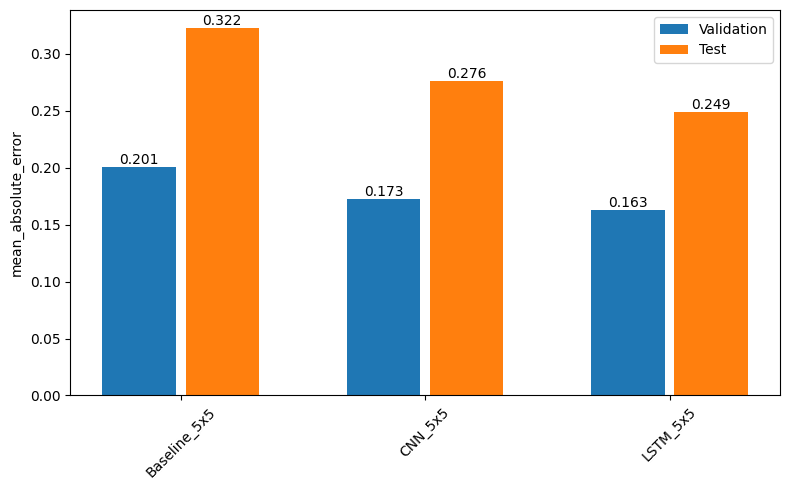

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'

# Pega o índice correto da métrica
metric_index = lstm_model.metrics_names.index("compile_metrics")

# Extrai os valores da métrica
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

# Cria o gráfico de barras
plt.figure(figsize=(8, 5))
plt.ylabel(metric_name)
bars1 = plt.bar(x - 0.17, val_mae, width, label='Validation')
bars2 = plt.bar(x + 0.17, test_mae, width, label='Test')

# Adiciona os valores no topo das barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.3f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.3f}', ha='center', va='bottom')

plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline_5x5: 0.3223
CNN_5x5     : 0.2757
LSTM_5x5    : 0.2493
